# Time Series Analysis: Part II

## 2. Using Linear Models

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()
from tqdm import tqdm_notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')


In [2]:
ads = pd.read_csv('./Downloads/ads.csv',index_col=['Time'],parse_dates=['Time'])
currency = pd.read_csv('./Downloads/currency.csv',index_col=['Time'],parse_dates=['Time'])

$\verb|currency|$ represents in game currency while $\verb|ads_wt|$ represent ads watch time.

In [3]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


### *1.* Feature Extraction

Since all we have is a time dependent series, therefore we have to extract specefic features to train our model upon.

A few of them are given below:-
* Given a window, we can:
    * Max/Min value of the series in the given window.
    * Mean and/or Variance of the values under the given window.
    * Position of Median of the values under the window.
    * etc.
* From the Time varying Index, we can:
    * Date, Day, Month, Time, Hours, etc. 
    * Whether a particular given day is a holiday or not.(Here, due to high complexity, we'll consider all 5 working days without any unusual holiday)   
* Encoding the target
* Shift and Learn (Lagging the current observation by $\verb|n|$ steps back)

#### *1.a.* Shift and Learn (Lag the Time Series)

We have to find a right balance between *Quality Prediction* and *Length of Forecasting Horizon*

In [4]:
data = pd.DataFrame(ads.Ads)

In [5]:
data.columns = ['y']

In [6]:
for i in range(6,25):
    data["lag_{}".format(i)] = data['y'].shift(i)

Since we have a Dataset with few featurs now, we'll try to fit this with a basic $\verb|LinearRegressor|$

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [8]:
tscv = TimeSeriesSplit(n_splits=4)

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def ts_test_train_split(X,y,train_size):
    
    train_index = int(len(X)*(train_size))
    
    X_train = X.iloc[:train_index]
    y_train = y.iloc[:train_index]
    
    X_test = X.iloc[train_index:]
    y_test = y.iloc[train_index:]
    
    return X_train, y_train, X_test, y_test




def PlotModelResults(model, y_test, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    
    
    
    predictions = model.predict(X_test)
    
    plt.figure(figsize = (12,6))
    
    plt.plot(predictions, 'g', label = 'Predictions')
    plt.plot(y_test.values, 'r', label = "Actual Values")
    
    
    if plot_intervals:
        cv = cross_val_score(model, X_test.values, predictions, cv = tscv, scoring = 'neg_mean_squared_error' )
        error = np.sqrt(np.std(cv)) #Just 'np.std(cv)' is way too high of a boundary
        lower_bound = predictions - error*scale
        higher_bound = predictions + error*scale
        
        plt.plot(lower_bound, 'b--', label = "Upper & Lower Bounds")
        plt.plot(higher_bound, 'b--')
        
        if plot_anomalies:
            
            dummy_test = np.array(len(y_test)*[None])
            dummy_test[(y_test.values < lower_bound) & (y_test.values > higher_bound)] = y_test.values[(y_test.values < lower_bound) & (y_test.values > higher_bound)]
            plt.plot(dummy_test,'go',label = 'Anomalies')
            
    
    mape = mean_absolute_percentage_error(y_test,predictions)
    plt.title("Mean Absolute Percentage Error: {}%".format(mape))
    plt.legend()
    plt.tight_layout()

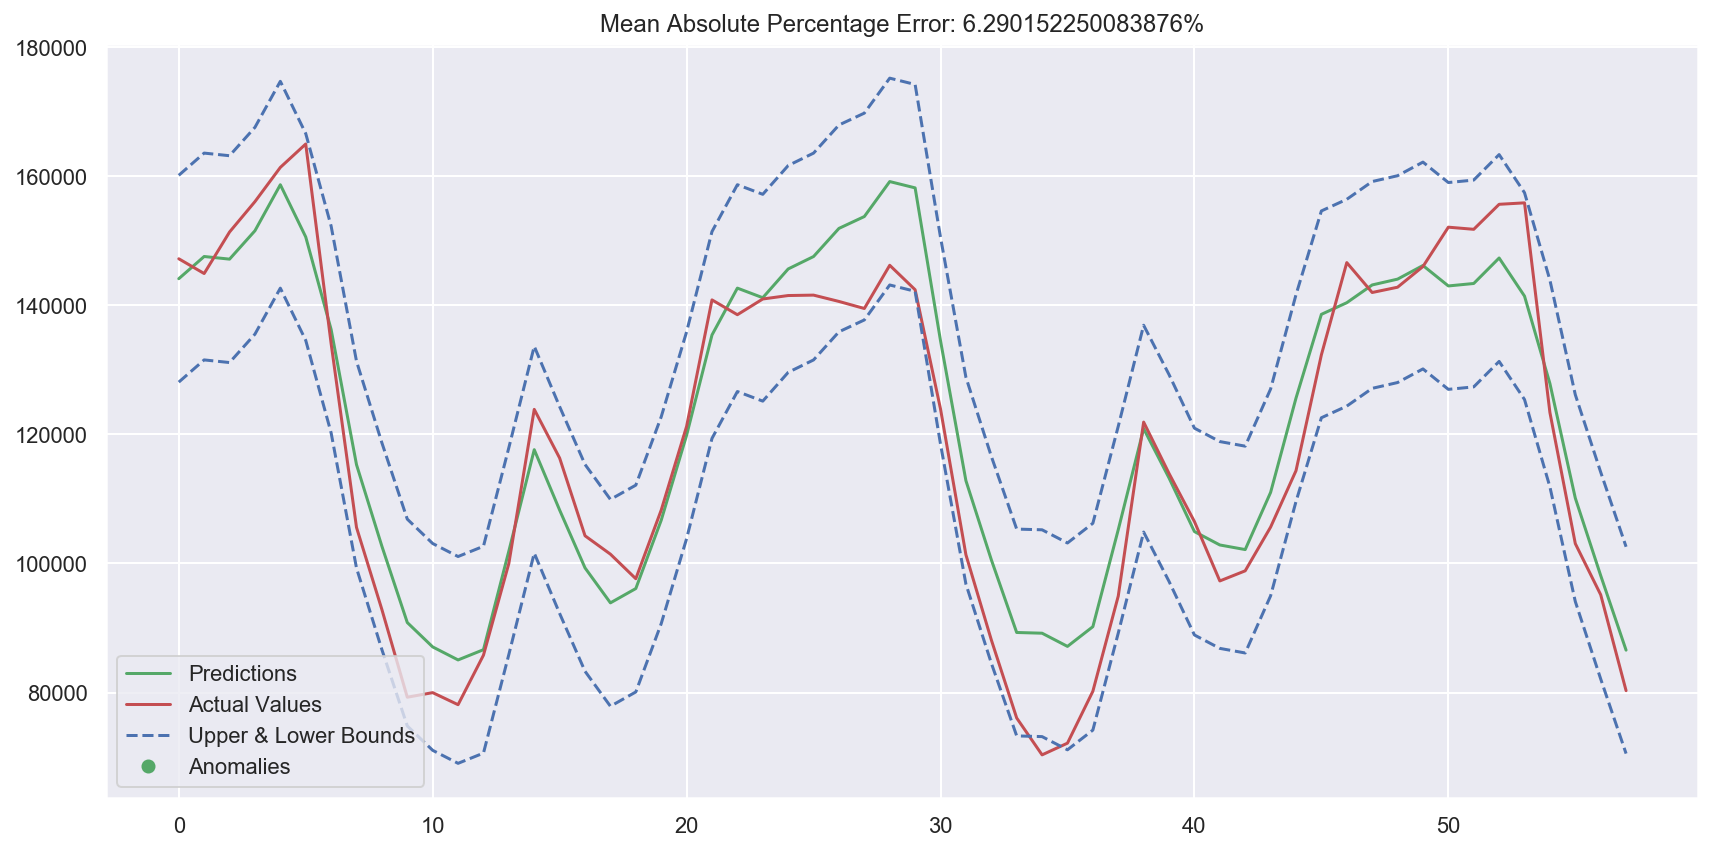

In [11]:
X = data.dropna().drop(['y'],axis = 1)
y = data.dropna().y

X_train, y_train, X_test, y_test = ts_test_train_split(X,y,0.7)

lin_regressor = LinearRegression()
lin_regressor.fit(X_train,y_train)

PlotModelResults(lin_regressor,y_test,X_test,plot_intervals=True,plot_anomalies=True)

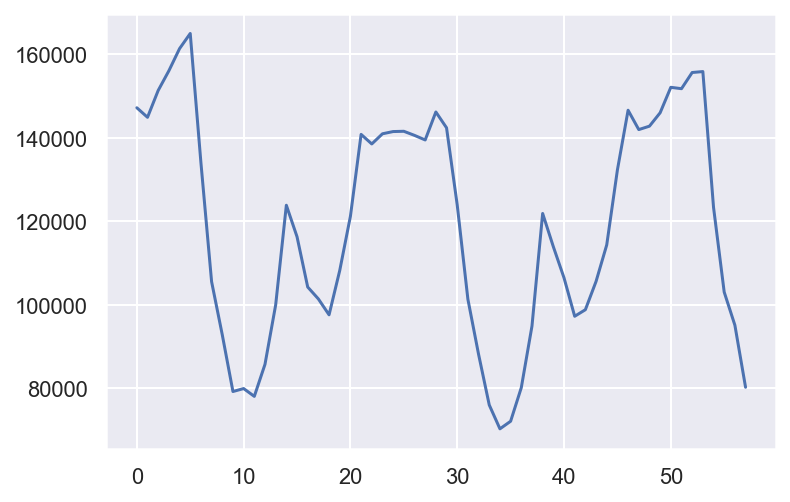

In [12]:
plt.plot(y_test.values)

## Using XGBoost Regressor

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

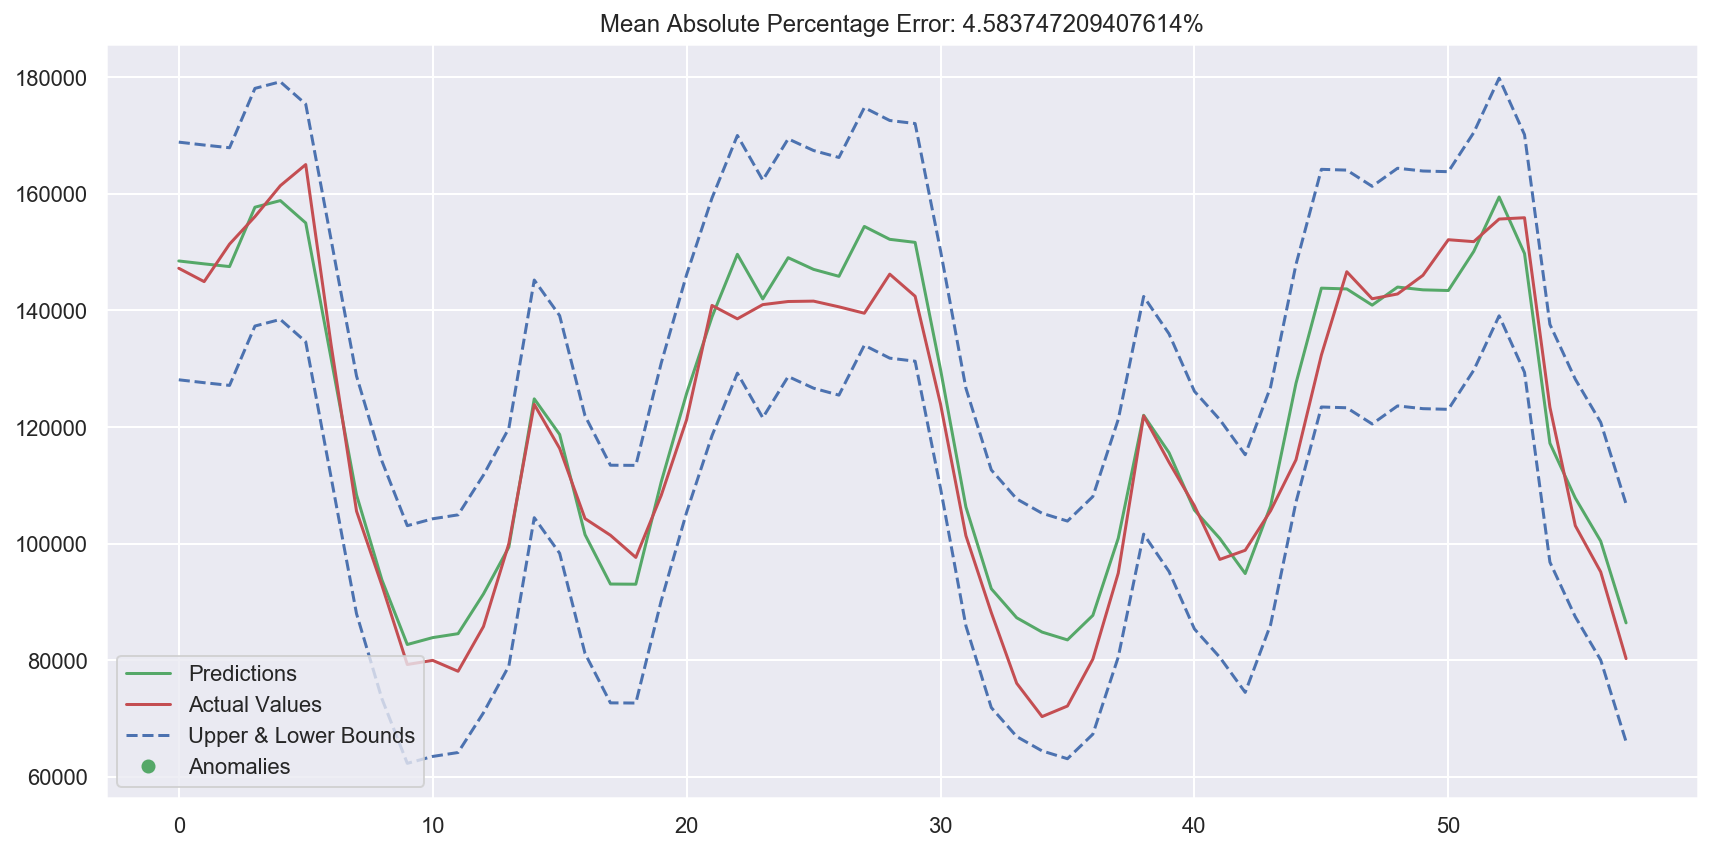

In [14]:
xgb_reg = GradientBoostingRegressor()
scaler = StandardScaler()
X_train_scaled = scaler.fit(X_train)
xgb_reg.fit(X_train,y_train)
PlotModelResults(xgb_reg,y_test,X_test,plot_intervals=True,plot_anomalies=True)

## The Problem Statement to work upon in future:-

Given a Time Series Data of Everyday Reach, predict the future Reach of the same Brand/Topic.

In [17]:
data

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-13 00:00:00,80115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 01:00:00,79885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 02:00:00,89325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 03:00:00,101930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 04:00:00,121630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 05:00:00,116475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 06:00:00,106495,80115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 07:00:00,102795,79885.0,80115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 08:00:00,108055,89325.0,79885.0,80115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
